
![Image Description](/images/Operations_Research_Methodology_Diagram.png)







In [54]:
#  pip install gurobipy

   ---------------------------------------- 10.3/10.3 MB 17.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
from datetime import datetime, timedelta, time
from pulp import (
    LpProblem,
    LpMinimize,
    LpVariable,
    lpSum,
    LpStatus,
    value,
    PULP_CBC_CMD,
)

file_path = r"C:\Users\Alvaro\Documents\Facultad\MBZUAI\Internship\Etihad\Internship\Zonal Allocation\Automated allocations\Automated Allocation Excel v7 - For tests.xlsm"
# Load data
manpower_df = pd.read_excel(file_path, sheet_name="Manpower")
flights_df = pd.read_excel(file_path, sheet_name="Flights")

# Let's handle the NaN values
manpower_df["Main Certifications"] = manpower_df["Main Certifications"].apply(
    lambda x: [] if pd.isna(x) else x
)
manpower_df["Cat-A Certifications"] = manpower_df["Cat-A Certifications"].apply(
    lambda x: [] if pd.isna(x) else x
)
# Extract certifiers, aircraft, bays, and shifts from the data
certifiers = manpower_df["Name"].unique()
aircraft_wp = flights_df["WP"].unique()
bays = flights_df["Bay"].unique()

# Create dictionaries for certifier and aircraft information
certifier_info = manpower_df.set_index("Name").to_dict("index")
aircraft_info = flights_df.set_index("WP").to_dict("index")

# Define what a long stop is, in minutes
long_stop = 5 * 60

In [19]:
############################ COSTS ############################


# Function to calculate movement cost (or time) between bays
# If they are of the same area (for instance, both are 600), I define the movement cost as 2 minutes per bay, with a maximum of 10 minutes
# If they are of different areas, I set the movement cost as 30 minutes
def calculate_movement_cost(bay1, bay2):
    if bay1 // 100 == bay2 // 100:
        return min(2 * abs(bay1 - bay2), 10)
    else:
        return 30

# Create a movement time matrix. This matrix will be for all the possible pairs of aircraft
movement_cost_matrix = {}
for a1 in aircraft_wp:
    for a2 in aircraft_wp:
        movement_cost_matrix[(a1, a2)] = calculate_movement_cost(
            aircraft_info[a1]["Bay"], aircraft_info[a2]["Bay"]
        )

# Cost of assigning a certifier to a bay zone
def calculate_bay_zone_cost(certifier, bay_zone):
    if certifier_info[certifier]["Primary Bay Zone"] == bay_zone:
        return 0
    else:
        return 200

# We can also define a cost of changing bay zones.
def calculate_zone_change_cost(bay_zone_1, bay_zone_2):
    if bay_zone_1 != bay_zone_2:
        return 100
    else:
        return 0

# Costs of assigning Main Certifier, Cat-A Certifier and someone with no certifications
# The No Certifications needs to be done in order to always get a solution
def calculate_certification_cost(certifier, aircraft):
    aircraft_type = aircraft_info[aircraft]["Aircraft type"]
    main_certifications = certifier_info[certifier]["Main Certifications"]
    cat_a_certifications = certifier_info[certifier]["Cat-A Certifications"]
    if aircraft_type in main_certifications:
        return 0
    elif aircraft_type in cat_a_certifications:
        return 50
    else:
        return 100000  # Large penalty to discourage assignment

# Cost of assigning a shift leader
def calculate_shift_leader_cost(certifier):
    if certifier_info[certifier]["Type"] == "LE":
        return 100
    else:
        return 0

# Cost of assigning a quality control certifier
# As the QC is also a shift leader (is this so?), his actual cost will be the quality control cost + the shift leader cost
def calculate_quality_control_cost(certifier):
    if certifier_info[certifier]["Primary Bay Zone"] == "QC":
        return 200
    else:
        return 0

# Define the cost for assigning multiple aircraft to the same certifier. It should not grow linearly, but more exponentially
# 1 aicraft -> 50, 2 aircraft -> 150, 3 aircraft -> 300, 4 aircraft -> 500, 5 aircraft -> 750, 6 aircraft -> 1050
# def calculate_assignment_cost(num_assigned_aircraft):
#     if num_assigned_aircraft == 0:
#         return 0
#     if num_assigned_aircraft == 1:
#         return 50
#     elif num_assigned_aircraft == 2:
#         return 150
#     elif num_assigned_aircraft == 3:
#         return 300
#     elif num_assigned_aircraft == 4:
#         return 500
#     elif num_assigned_aircraft == 5:
#         return 750
#     elif num_assigned_aircraft == 6:
#         return 1050
#     else:
#         return 2000


def calculate_assignment_cost(num_assigned_aircraft):
    if num_assigned_aircraft <= 0.9:
        return 0
    elif num_assigned_aircraft <= 1.5:
        return 50
    elif num_assigned_aircraft <= 2.5:
        return 150
    elif num_assigned_aircraft <= 3.5:
        return 300
    elif num_assigned_aircraft <= 4.5:
        return 500
    elif num_assigned_aircraft <= 5.5:
        return 750
    elif num_assigned_aircraft <= 6.5:
        return 1050
    elif num_assigned_aircraft <= 7:
        return 1400
    else:
        return 2500

# Define the cost of assigning aicraft with similar departure time. If he is a Cat-A, he shouldn't be assigned to two aircrafts with close departure times
def calculate_similar_departure_time_cost(certifier, departure_time_1, departure_time_2):
    if abs(departure_time_1 - departure_time_2) < timedelta(minutes=30):
        if len(certifier_info[certifier]["Cat-A Certifications"]) > 0:
            return 1500
        else:
            return 100
    else:
        return 0

# Define the cost of assigning aicraft with similar arrival time. If he is a Cat-A, he shouldn't be assigned to two aircrafts with close arrivals
def calculate_similar_arrival_time_cost(certifier, arrival_time_1, arrival_time_2):
    if abs(arrival_time_1 - arrival_time_2) < timedelta(minutes=10):
        if len(certifier_info[certifier]["Cat-A Certifications"]) > 0:
            return 1500
        else:
            return 100
    else:
        return 0


# Define the cost of assigning aicraft looking at the times and shedules
def calculate_overlapping_time_cost(
    certifier,
    departure_time_1,
    arrival_time_1,
    departure_time_2,
    arrival_time_2,
    ground_time_1,
    ground_time_2,
):
    if ground_time_1 > long_stop or ground_time_2 > long_stop:
        return 0
    elif (arrival_time_1 < departure_time_2 and arrival_time_2 < departure_time_1) or (
        arrival_time_2 < departure_time_1 and arrival_time_1 < departure_time_2
    ):
        if certifier_info[certifier]["Cat-A Certifications"] != "":
            return 250
        else:
            return 100
    else:
        return 0


# Cost of assigning many long stops?

############################ COSTS ############################

In [20]:
# Initialize the problem
problem = LpProblem("Aircraft_Assignment", LpMinimize)
total_cost = 0

# Define decision variables
assignment = LpVariable.dicts("Assign", (certifiers, aircraft_wp), 0, 1, cat="Binary")

# Auxiliary variables for movement
movement = LpVariable.dicts(
    "Movement", (certifiers, aircraft_wp, aircraft_wp), 0, 1, cat="Binary"
)

# Calculate total costs
movement_cost_total = lpSum(
    [
        movement_cost_matrix[(a1, a2)] * movement[c][a1][a2]
        + calculate_zone_change_cost(aircraft_info[a1]["Bay"], aircraft_info[a2]["Bay"])
        * movement[c][a1][a2]
        for c in certifiers
        for a1 in aircraft_wp
        for a2 in aircraft_wp
    ]
)

bay_assignment_cost_total = lpSum(
    [
        calculate_bay_zone_cost(c, aircraft_info[a]["Bay Zone"]) * assignment[c][a]
        for c in certifiers
        for a in aircraft_wp
    ]
)


similar_departure_time_cost_total = lpSum(
    [
        calculate_similar_departure_time_cost(
            c, aircraft_info[a1]["Departure time"], aircraft_info[a2]["Departure time"]
        )
        * movement[c][a1][a2]
        for a1 in aircraft_wp
        for a2 in aircraft_wp
        for c in certifiers
        if a1 != a2
    ]
)

similar_arrival_time_cost_total = lpSum(
    [
        calculate_similar_arrival_time_cost(
            c, aircraft_info[a1]["Arrival time"], aircraft_info[a2]["Arrival time"]
        )
        * movement[c][a1][a2]
        for a1 in aircraft_wp
        for a2 in aircraft_wp
        for c in certifiers
        if a1 != a2
    ]
)

# Define binary variables for assignment cost function
assignment_costs = {
    c: LpVariable.dicts(f"AssignmentCost_{c}", range(7), 0, 1, cat="Binary")
    for c in certifiers
}

# Calculate assignment costs and add them to the total cost
assignment_cost_total = lpSum(
    [
        calculate_assignment_cost(i) * assignment_costs[c][i]
        for c in certifiers
        for i in range(7)
    ]
)

for c in certifiers:
    # Ensure that exactly one cost level is selected
    problem += lpSum([assignment_costs[c][i] for i in range(7)]) == 1

    # Link assignment cost levels to the number of assigned aircraft
    problem += lpSum([assignment[c][a] for a in aircraft_wp]) == lpSum(
        [i * assignment_costs[c][i] for i in range(7)]
    )

# Add the additional cost components to the total cost
certification_shift_quality_cost_total = lpSum(
    [
        assignment[c][a]
        * (
            calculate_certification_cost(c, a)
            + calculate_shift_leader_cost(c)
            + calculate_quality_control_cost(c)
        )
        for c in certifiers
        for a in aircraft_wp
    ]
)

overlapping_time_cost_total = lpSum(
    [
        calculate_overlapping_time_cost(
            c,
            aircraft_info[a1]["Departure time"],
            aircraft_info[a1]["Arrival time"],
            aircraft_info[a2]["Departure time"],
            aircraft_info[a2]["Arrival time"],
            aircraft_info[a1]["Ground Time (minutes)"],
            aircraft_info[a2]["Ground Time (minutes)"],
        )
        * movement[c][a1][a2]
        for a1 in aircraft_wp
        for a2 in aircraft_wp
        for c in certifiers
        if a1 != a2
    ]
)

# Add all components to the total cost
total_cost = (
    movement_cost_total
    + bay_assignment_cost_total
    + similar_departure_time_cost_total
    + similar_arrival_time_cost_total
    + assignment_cost_total
    + overlapping_time_cost_total
    + certification_shift_quality_cost_total
)

# Add the total cost to the problem
problem += total_cost, "Minimize_Total_Cost"

# Constraints
# Each aircraft should be assigned to exactly one certifier
for a in aircraft_wp:
    problem += lpSum([assignment[c][a] for c in certifiers]) == 1

# # Certifiers should be assigned to aircraft they have certification, as Main Certification or Cat-A certification. If they don't have it, they can't be assigned
# for c in certifiers:
#     for a in aircraft_wp:
#         if (
#             aircraft_info[a]["Aircraft type"]
#             not in certifier_info[c]["Main Certifications"]
#             and aircraft_info[a]["Aircraft type"]
#             not in certifier_info[c]["Cat-A Certifications"]
#         ):
#             problem += assignment[c][a] == 0

# Add the constraint that certifiers should be assigned to aircraft in their shift range + 1 hour
for c in certifiers:
    for a in aircraft_wp:
        arrival_time = aircraft_info[a]["Arrival time"]
        departure_time = aircraft_info[a]["Departure time"]

        shift_start_buffered = certifier_info[c]["Shift Start"] - timedelta(hours=1)
        shift_end_buffered = certifier_info[c]["Shift End"] + timedelta(hours=1)

        # Check if the aircraft's arrival or departure time falls within the buffered shift range
        if not (
            shift_start_buffered <= arrival_time <= shift_end_buffered
            or shift_start_buffered <= departure_time <= shift_end_buffered
        ):
            problem += assignment[c][a] == 0

# # Certifiers should be assigned to a maximum of 2 aircraft with long layovers
# for c in certifiers:
#     problem += (
#         lpSum(
#             [
#                 assignment[c][a]
#                 for a in aircraft_wp
#                 if aircraft_info[a]["Ground Time (minutes)"] > long_stop
#             ]
#         )
#         <= 2
#     )

# Link movement variables with assignments
for c in certifiers:
    for a1 in aircraft_wp:
        for a2 in aircraft_wp:
            if a1 != a2:
                problem += (
                    movement[c][a1][a2] >= assignment[c][a1] + assignment[c][a2] - 1
                )
                problem += movement[c][a1][a2] <= assignment[c][a1]
                problem += movement[c][a1][a2] <= assignment[c][a2]


# Solve the problem
# solver = PULP_CBC_CMD(msg=1, timeLimit=160, presolve="on", strong=2, gapRel=0.2)
solver = PULP_CBC_CMD(msg=1, timeLimit=1200, presolve="on", strong=2, gapRel=0.6)
problem.solve(solver)

# Check the solution
print(f"Status: {LpStatus[problem.status]}")
total_cost_value = value(problem.objective)
print(f"Total cost: {total_cost_value}")

# Detailed cost breakdown
print("Detailed Cost Breakdown:")
movement_cost_value = value(movement_cost_total)
assignment_cost_value = value(assignment_cost_total)
certification_shift_quality_cost_value = value(certification_shift_quality_cost_total)
similar_departure_time_cost_value = value(similar_departure_time_cost_total)
similar_arrival_time_cost_value = value(similar_arrival_time_cost_total)
overlapping_time_cost_value = value(overlapping_time_cost_total)
bay_assignment_cost_value = value(bay_assignment_cost_total)

print(f"Movement cost: {movement_cost_value}")
print(f"Assignment cost: {assignment_cost_value}")
print(
    f"Certification, shift leader, and quality control cost: {certification_shift_quality_cost_value}"
)
print(f"Similar departure time cost: {similar_departure_time_cost_value}")
print(f"Similar arrival time cost: {similar_arrival_time_cost_value}")
print(f"Overlapping time cost: {overlapping_time_cost_value}")
print(f"Bay assignment cost: {bay_assignment_cost_value}")

for c in certifiers:
    for a in aircraft_wp:
        if assignment[c][a].varValue == 1:
            print(f"Certifier {c} is assigned to Aircraft {a}")

# Print the costs and assignments
no_certification_assignments = []

for c in certifiers:
    num_aircraft_assigned = sum(assignment[c][a].varValue for a in aircraft_wp)
    assignment_cost = calculate_assignment_cost(num_aircraft_assigned)
    print(f"Certifier {c}:")
    print(f"  Number of aircraft assigned: {num_aircraft_assigned}")
    print(f"  Assignment cost: {assignment_cost}")

    movement_cost = 0
    zone_change_cost = 0
    similar_departure_time_cost = 0
    similar_arrival_time_cost = 0
    overlapping_time_cost = 0
    bay_assignment_cost = 0
    assigned_aircraft = [a for a in aircraft_wp if assignment[c][a].varValue == 1]

    for i in range(len(assigned_aircraft)):
        for j in range(i + 1, len(assigned_aircraft)):
            a1 = assigned_aircraft[i]
            a2 = assigned_aircraft[j]
            movement_cost += movement_cost_matrix[(a1, a2)]
            zone_change_cost += calculate_zone_change_cost(
                aircraft_info[a1]["Bay"], aircraft_info[a2]["Bay"]
            )
            similar_departure_time_cost += calculate_similar_departure_time_cost(
                c,
                aircraft_info[a1]["Departure time"],
                aircraft_info[a2]["Departure time"],
            )
            similar_arrival_time_cost += calculate_similar_arrival_time_cost(
                c, aircraft_info[a1]["Arrival time"], aircraft_info[a2]["Arrival time"]
            )
            overlapping_time_cost += calculate_overlapping_time_cost(
                c,
                aircraft_info[a1]["Departure time"],
                aircraft_info[a1]["Arrival time"],
                aircraft_info[a2]["Departure time"],
                aircraft_info[a2]["Arrival time"],
                aircraft_info[a1]["Ground Time (minutes)"],
                aircraft_info[a2]["Ground Time (minutes)"],
            )

    bay_assignment_cost = sum(
        calculate_bay_zone_cost(c, aircraft_info[a]["Bay Zone"])
        * assignment[c][a].varValue
        for a in aircraft_wp
    )

    print(f"  Movement cost: {movement_cost}")
    print(f"  Zone change cost: {zone_change_cost}")
    print(f"  Similar departure time cost: {similar_departure_time_cost}")
    print(f"  Similar arrival time cost: {similar_arrival_time_cost}")
    print(f"  Overlapping time cost: {overlapping_time_cost}")
    print(f"  Bay assignment cost: {bay_assignment_cost}")

    certification_shift_quality_cost = sum(
        assignment[c][a].varValue
        * (
            calculate_certification_cost(c, a)
            + calculate_shift_leader_cost(c)
            + calculate_quality_control_cost(c)
        )
        for a in aircraft_wp
    )
    print(
        f"  Certification, shift leader, and quality control cost: {certification_shift_quality_cost}"
    )

    for a in assigned_aircraft:
        certification_cost = calculate_certification_cost(c, a)
        print(f"  Aircraft {a}:")
        print(f"    Certification cost: {certification_cost}")
        if certification_cost == 100000:
            no_certification_assignments.append((c, a))

# Print assignments without certifications
if no_certification_assignments:
    print("Assignments without proper certifications:")
    for certifier, aircraft in no_certification_assignments:
        print(
            f"  Certifier {certifier} is assigned to Aircraft {aircraft} without proper certification"
        )

# Print total cost
total_cost_value = value(problem.objective)
print(f"Total cost: {total_cost_value}")

# Print final assignments
for c in certifiers:
    for a in aircraft_wp:
        if assignment[c][a].varValue == 1:
            print(f"Certifier {c} is assigned to Aircraft {a}")

Status: Optimal
Total cost: 2752.0
Detailed Cost Breakdown:
Movement cost: 652.0
Assignment cost: 600.0
Certification, shift leader, and quality control cost: 0
Similar departure time cost: 200.0
Similar arrival time cost: 200.0
Overlapping time cost: 500.0
Bay assignment cost: 600.0
Certifier A.OBAID is assigned to Aircraft AEG/WP
Certifier A.OBAID is assigned to Aircraft AEH/WP
Certifier A.OBAID is assigned to Aircraft AEO/WP
Certifier A.SHUAIBI is assigned to Aircraft AEB/L-150724-2
Certifier A.SHUAIBI is assigned to Aircraft AEC/L-150724-2
Certifier SANDEEP is assigned to Aircraft AED/L-150724-2
Certifier SANDEEP is assigned to Aircraft AEF/WP
Certifier A.OBAID:
  Number of aircraft assigned: 3.0
  Assignment cost: 300
  Movement cost: 16
  Zone change cost: 200
  Similar departure time cost: 100
  Similar arrival time cost: 100
  Overlapping time cost: 250
  Bay assignment cost: 0.0
  Certification, shift leader, and quality control cost: 0.0
  Aircraft AEG/WP:
    Certification c

In [11]:
import pandas as pd
import openpyxl
from openpyxl.styles import Font, Color, PatternFill

# Initialize lists to store the data
data = []
summary_data = []
total_cost_data = []

no_certification_assignments = []

for c in certifiers:
    num_aircraft_assigned = sum(assignment[c][a].varValue for a in aircraft_wp)
    assignment_cost = calculate_assignment_cost(num_aircraft_assigned)

    movement_cost = 0
    zone_change_cost = 0
    similar_departure_time_cost = 0
    similar_arrival_time_cost = 0
    overlapping_time_cost = 0
    assigned_aircraft = [a for a in aircraft_wp if assignment[c][a].varValue == 1]

    for i in range(len(assigned_aircraft)):
        for j in range(i + 1, len(assigned_aircraft)):
            a1 = assigned_aircraft[i]
            a2 = assigned_aircraft[j]
            movement_cost += movement_cost_matrix[(a1, a2)]
            zone_change_cost += calculate_zone_change_cost(
                aircraft_info[a1]["Bay"], aircraft_info[a2]["Bay"]
            )
            similar_departure_time_cost += calculate_similar_departure_time_cost(
                c,
                aircraft_info[a1]["Departure time"],
                aircraft_info[a2]["Departure time"],
            )
            similar_arrival_time_cost += calculate_similar_arrival_time_cost(
                c, aircraft_info[a1]["Arrival time"], aircraft_info[a2]["Arrival time"]
            )
            overlapping_time_cost += calculate_overlapping_time_cost(
                c,
                aircraft_info[a1]["Departure time"],
                aircraft_info[a1]["Arrival time"],
                aircraft_info[a2]["Departure time"],
                aircraft_info[a2]["Arrival time"],
                aircraft_info[a1]["Ground Time (minutes)"],
                aircraft_info[a2]["Ground Time (minutes)"],
            )

    certification_shift_quality_cost = sum(
        assignment[c][a].varValue
        * (
            calculate_certification_cost(c, a)
            + calculate_shift_leader_cost(c)
            + calculate_quality_control_cost(c)
        )
        for a in aircraft_wp
    )

    total_cost = (
        assignment_cost
        + movement_cost
        + zone_change_cost
        + similar_departure_time_cost
        + similar_arrival_time_cost
        + overlapping_time_cost
        + certification_shift_quality_cost
    )

    summary_data.append(
        {
            "Certifier": c,
            "Number of Aircraft Assigned": num_aircraft_assigned,
            "Assignment Cost": assignment_cost,
            "Movement Cost": movement_cost,
            "Zone Change Cost": zone_change_cost,
            "Similar Departure Time Cost": similar_departure_time_cost,
            "Similar Arrival Time Cost": similar_arrival_time_cost,
            "Overlapping Time Cost": overlapping_time_cost,
            "Certification, Shift Leader, and Quality Control Cost": certification_shift_quality_cost,
            "Total Cost": total_cost,
        }
    )

    for a in assigned_aircraft:
        certification_cost = calculate_certification_cost(c, a)
        data.append(
            {
                "Certifier": c,
                "Aircraft": a,
                "Number of Aircraft Assigned": num_aircraft_assigned,
                "Assignment Cost": assignment_cost,
                "Movement Cost": movement_cost,
                "Zone Change Cost": zone_change_cost,
                "Similar Departure Time Cost": similar_departure_time_cost,
                "Similar Arrival Time Cost": similar_arrival_time_cost,
                "Overlapping Time Cost": overlapping_time_cost,
                "Certification, Shift Leader, and Quality Control Cost": certification_shift_quality_cost,
                "Certification Cost": certification_cost,
            }
        )
        if certification_cost == 100000:
            no_certification_assignments.append((c, a))

# Print assignments without certifications
if no_certification_assignments:
    print("Assignments without proper certifications:")
    for certifier, aircraft in no_certification_assignments:
        print(
            f"  Certifier {certifier} is assigned to Aircraft {aircraft} without proper certification"
        )

# Print total cost
total_cost_value = value(problem.objective)
print(f"Total cost: {total_cost_value}")

# Create DataFrames
df = pd.DataFrame(data)
summary_df = pd.DataFrame(summary_data)
total_cost_df = pd.DataFrame([{"Total Cost": total_cost_value}])

# Write to Excel
with pd.ExcelWriter("assignment_costs.xlsx", engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="Detailed Costs", index=False)
    summary_df.to_excel(writer, sheet_name="Summary Assignments", index=False)
    total_cost_df.to_excel(writer, sheet_name="Total Cost", index=False)

    # Access the workbook and the sheets
    workbook = writer.book
    detailed_costs_sheet = workbook["Detailed Costs"]
    summary_assignments_sheet = workbook["Summary Assignments"]
    total_cost_sheet = workbook["Total Cost"]

    # Define some styles
    header_font = Font(bold=True, color="FFFFFF")
    header_fill = PatternFill(
        start_color="4F81BD", end_color="4F81BD", fill_type="solid"
    )

    # Apply styles to headers
    for sheet in [detailed_costs_sheet, summary_assignments_sheet, total_cost_sheet]:
        for cell in sheet["1:1"]:
            cell.font = header_font
            cell.fill = header_fill

    # Highlight total costs in the summary sheet
    for row in summary_assignments_sheet.iter_rows(
        min_row=2,
        max_row=summary_assignments_sheet.max_row,
        min_col=summary_assignments_sheet.max_column,
        max_col=summary_assignments_sheet.max_column,
    ):
        for cell in row:
            cell.font = Font(bold=True)
            cell.fill = PatternFill(
                start_color="FFC7CE", end_color="FFC7CE", fill_type="solid"
            )

print("All costs and assignments have been saved to 'assignment_costs.xlsx'.")

Total cost: 2186.0
All costs and assignments have been saved to 'assignment_costs.xlsx'.


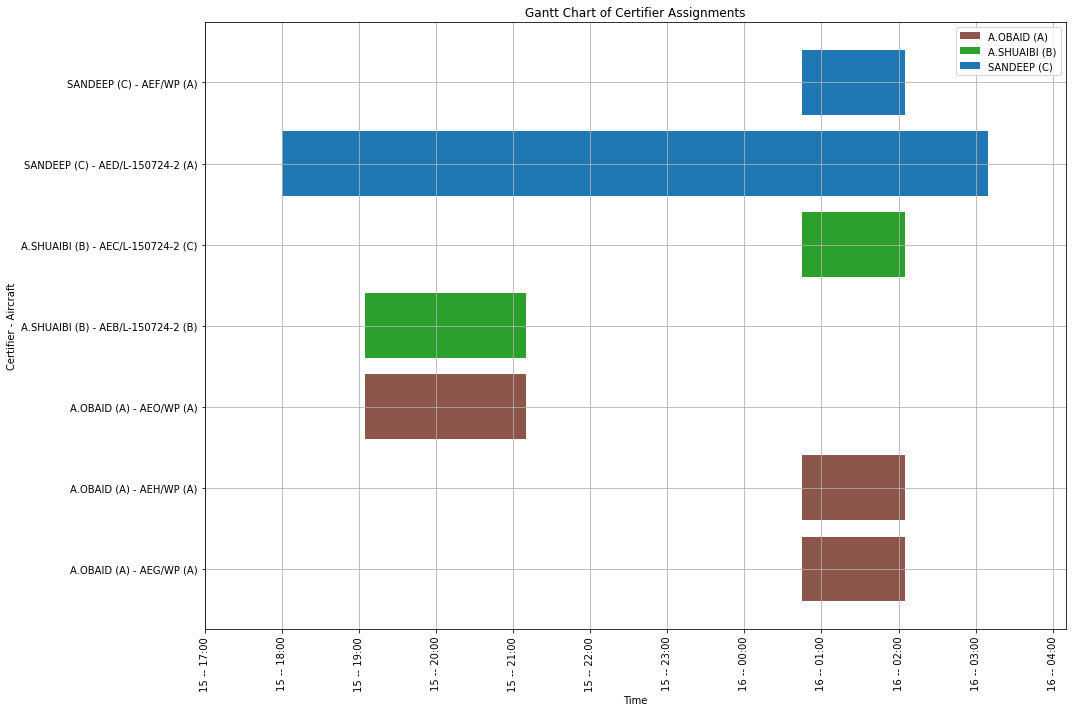

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np

# Prepare the data for Gantt chart
gantt_data = []

for c in certifiers:
    assigned_aircraft = [a for a in aircraft_wp if assignment[c][a].varValue == 1]
    for index, a in enumerate(assigned_aircraft):
        arrival_time = pd.to_datetime(aircraft_info[a]["Arrival time"])
        departure_time = pd.to_datetime(aircraft_info[a]["Departure time"])
        certifier_label = f"{c} ({certifier_info[c]['Primary Bay Zone']})"
        aircraft_label = f"{a} ({aircraft_info[a]['Bay Zone']})"
        gantt_data.append(
            {
                "Certifier": certifier_label,
                "Aircraft": aircraft_label,
                "Start": arrival_time,
                "Finish": departure_time,
                "Line": f"{certifier_label} - {aircraft_label}",
            }
        )

gantt_df = pd.DataFrame(gantt_data)

# Convert the times to matplotlib's internal format
gantt_df["Start_num"] = mdates.date2num(gantt_df["Start"])
gantt_df["Finish_num"] = mdates.date2num(gantt_df["Finish"])
gantt_df["Duration"] = gantt_df["Finish_num"] - gantt_df["Start_num"]

# Find the earliest start time and latest finish time to set as the x-axis limit
earliest_start = gantt_df["Start"].min() - pd.Timedelta(hours=1)
latest_finish = gantt_df["Finish"].max() + pd.Timedelta(hours=1)

# Convert to matplotlib's internal format
earliest_start_num = mdates.date2num(earliest_start)
latest_finish_num = mdates.date2num(latest_finish)

# Create the Gantt chart
fig, ax = plt.subplots(figsize=(15, 10))

# Use a predefined list of distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, 20))

# Shuffle the colors to avoid adjacent colors being too similar
np.random.shuffle(colors)

# Take only the unique certifiers
unique_certifiers = gantt_df["Certifier"].unique()

# Plot each assignment
color_dict = {
    certifier: colors[i % len(colors)] for i, certifier in enumerate(unique_certifiers)
}

for certifier in unique_certifiers:
    df_cert = gantt_df[gantt_df["Certifier"] == certifier]
    color = color_dict[certifier]
    for _, row in df_cert.iterrows():
        ax.barh(
            row["Line"],
            row["Duration"],
            left=row["Start_num"],
            align="center",
            color=color,
            label=row["Certifier"],
        )

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Format the x-axis to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d -- %H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d -- %H:%M"))

# Set x-axis limits
ax.set_xlim(earliest_start_num, latest_finish_num)

plt.xlabel("Time")
plt.ylabel("Certifier - Aircraft")
plt.title("Gantt Chart of Certifier Assignments")
plt.grid(True)

plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()